# Sine Walk Frequency Analysis

## Overview
This Python script processes markdown and CSV files containing time (s), latitude, and longitude
data located in 'directory' folder. It extracts temperature data from markdown files, converts it
to Kelvin, and then uses CSV files for fitting, Fourier transforms (FFT), and inverse FFT processing.
The script generates plots of raw and fitted data, as well as their frequency components.

### Key Features:
- Extracts temperature from markdown files and converts it to Kelvin.
- Fits sine curves to CSV data and plots both raw and fitted data.
- Computes FFT for the fitted data and plots the frequency spectrum.
- Applies a low-pass filter to the FFT result and computes the inverse FFT.
- Generates three distinct plots:
  1. **Fit vs Raw Data**: Shows raw data and sine wave fits.
  2. **FFT Plot**: Shows the frequency spectrum of the fitted data.
  3. **Inverse FFT Plot**: Displays the inverse FFT of the filtered frequencies.

### Requirements

To run this script, you need the following Python libraries:

- `numpy`
- `matplotlib`

### How to Run the Code

Click 'Execute cell' from the code block and the script will then ask for the following inputs:

- Enter the directory path containing markdown and CSV files: "/path/to/directory"
- Enter a keyword to filter markdown files (or press Enter to skip):
- Enter the step exponent for downsampling (e.g., 0 for no downsampling):

Once you have entered the path to the directory, the filter word and the step exponent value,
for listing the markdown files, the code will execute. The script will process the markdown files, 
extracting temperature values and converting them to Kelvin. The extracted temperatures will be 
included in the plot legends. The script will fit each sinewalk CSV file's data to a sine wave and 
then compute the FFT of the fitted data. The raw data, the fitted curve, the FFT magnitude, and the 
inverse FFT of the filtered frequencies will be plotted in three separate figures.

## Sources
- ifft — SciPy v1.14.1 Manual. (n.d.). https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.ifft.html
  * Explains the ifft function in SciPy, which computes the 1-D inverse discrete Fourier Transform (IDFT) of an input array. The ifft function is the inverse operation of the forward Fourier Transform (fft) and is used to reconstruct a time-domain signal from its frequency-domain representation.
- Discrete Fourier Transform (Numpy.FFT) — NUMPY v2.1 Manual. (n.d.). https://numpy.org/doc/2.1/reference/routines.fft.html
  * Provides an extensive overview of the Discrete Fourier Transform (DFT) in NumPy, focusing on its implementation in the numpy.fft module.
- re — Regular expression operations. (n.d.). Python Documentation. https://docs.python.org/3/library/re.html
  * Explains Python's re module, which provides tools for working with regular expressions (regex). It covers the module's purpose, basic usage, syntax, and some technical considerations.
- GeeksforGeeks. (2022, August 6). SCIPY | Curve fitting. GeeksforGeeks. https://www.geeksforgeeks.org/scipy-curve-fitting/
  * Explains curve fitting using Python's SciPy library, specifically the curve_fit() function from the scipy.optimize module.



Markdown files found:
1. pp17_sinewalk.md
2. pp20_sinewalk.md
3. pp04_sinewalk.md
4. pp14_sinewalk.md
5. pp18_sinewalk.md
6. pp01_sinewalk.md
7. pp08_sinewalk.md
8. pp02_sinewalk.md
9. pp11_sinewalk.md
10. pp13_sinewalk.md
11. pp12_sinewalk.md
12. pp05_sinewalk.md
13. pp03_sinewalk.md
14. pp15_sinewalk.md
15. pp09_sinewalk.md
16. pp06_sinewalk.md
17. pp10_sinewalk.md
18. pp07_sinewalk.md
19. pp19_sinewalk.md
20. pp16_sinewalk.md


/workspaces/FORKCP1-24-final/p_pxmpo/code/final.py:125: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(sine_wave, x_data, y_data, p0=initial_guess)


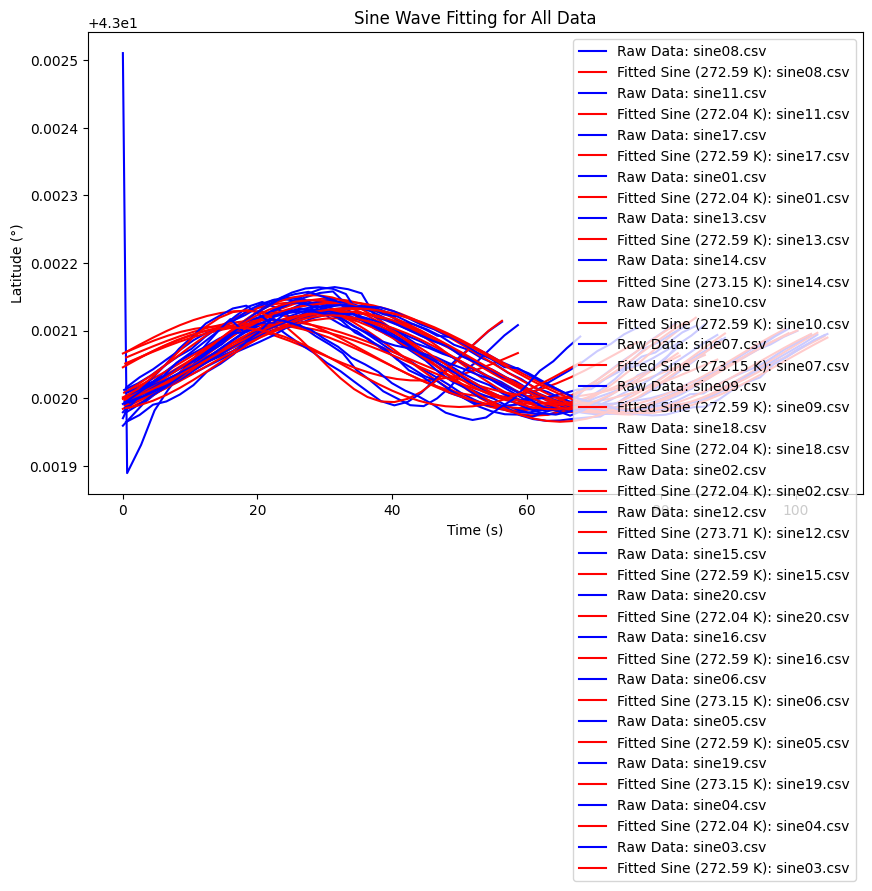

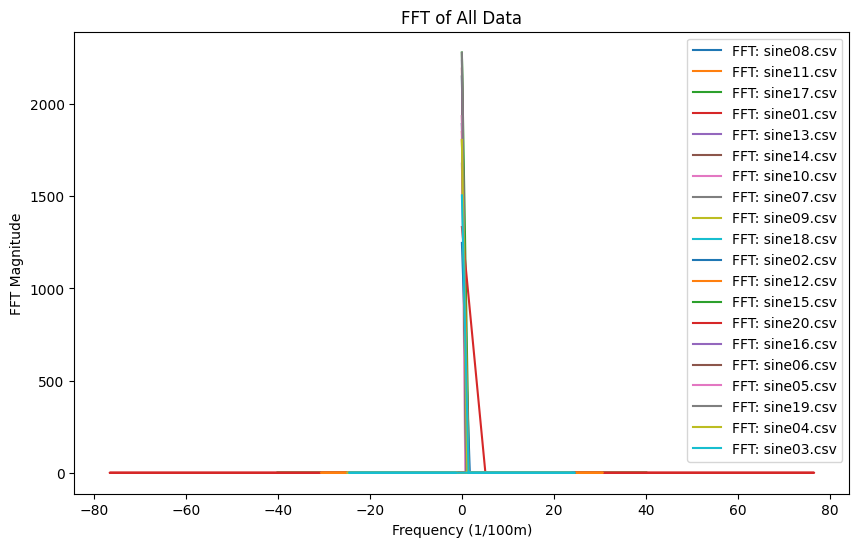

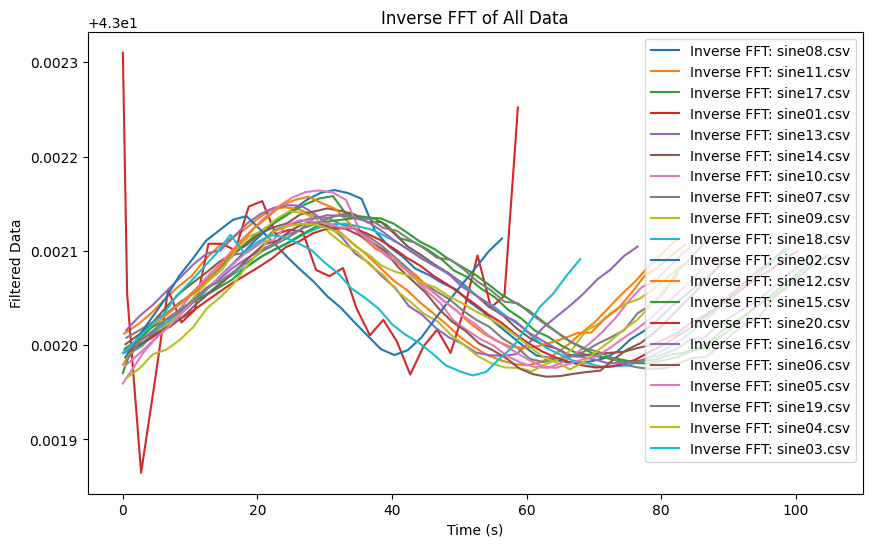

In [1]:
"""
This script processes markdown and CSV files in a specified directory. It extracts temperature
data from markdown files, converts the temperatures to Kelvin, and fits sine waves to the data
in CSV files. The script also computes and visualizes the FFT and inverse FFT of the data, and
displays the results in plots with temperature annotations in the legends.
"""
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/workspaces/FORKCP1-24-final/p_pxmpo/code')

from final import (
    extract_temperature_from_markdown,
    fahrenheit_to_kelvin,
    nonlinear_sine_fit,
    compute_fft,
    compute_inverse_fft,
)

def main():
    '''
    Main function to process the markdown files, extract temperatures, convert to Kelvin,
    and plot all results including temperatures in the legend.
    '''
    directory = input("Enter the directory containing markdown and CSV files: ")
    
    # Check if the directory exists
    if not os.path.exists(directory):
        print(f"Error: The directory '{directory}' does not exist.")
        return

    keyword = input("Enter a keyword for filtering markdown files (leave blank to skip filtering): ")

    # Filter markdown files based on the keyword
    markdown_files = []
    if keyword:
        markdown_files = [
            file for file in os.listdir(directory) if keyword in file and file.endswith(".md")
        ]
    else:
        markdown_files = [file for file in os.listdir(directory) if file.endswith(".md")]

    # Print list of markdown files
    if markdown_files:
        print("\nMarkdown files found:")
        for i, file in enumerate(markdown_files, 1):
            print(f"{i}. {file}")
    else:
        print("No markdown files found.")
        return  # Stop further execution if no markdown files are found

    # Extract temperatures from markdown files
    temperatures = []
    for file in markdown_files:
        file_path = os.path.join(directory, file)
        try:
            temp, unit = extract_temperature_from_markdown(file_path)
            if temp is not None:
                # Convert the temperature to Kelvin if needed
                if unit == "°F":
                    temp = fahrenheit_to_kelvin(temp)
                elif unit == "°C":
                    temp += 273.15
                temperatures.append((file, temp))
        except Exception as e:
            print(f"Error processing {file}: {e}")

    # Process CSV files
    csv_files = [f for f in os.listdir(directory) if f.endswith(".csv")]
    if not csv_files:
        print("No CSV files found.")
        return

    step_exponent = int(input("Enter step exponent for downsampling the data (e.g., 0 for no downsampling): "))

    # Store data for plotting
    all_sine_params = []
    all_fft_freqs = []
    all_fft_mags = []
    all_inverse_fft_data = []

    for csv_file in csv_files:
        csv_file_path = os.path.join(directory, csv_file)
        try:
            popt, pcov, x_data, y_data = nonlinear_sine_fit(csv_file_path, step_exponent)
            if popt is not None:
                all_sine_params.append((csv_file, x_data, y_data, popt))

                fft_freq, fft_magnitude, fft_result = compute_fft(y_data, x_data)
                all_fft_freqs.append((csv_file, fft_freq, fft_magnitude))

                filter_mask = np.abs(fft_freq) < 50  # Low-pass filter
                inverse_fft_result = compute_inverse_fft(fft_result, filter_mask)
                all_inverse_fft_data.append((csv_file, x_data, inverse_fft_result))
        except Exception as e:
            print(f"Error processing {csv_file}: {e}")

    # Plot data only if there are markdown files
    if markdown_files:
        if all_sine_params:
            plt.figure(figsize=(10, 6))
            for (csv_file, x_data, y_data, popt), (markdown_file, kelvin_temp) in zip(all_sine_params, temperatures):
                plt.plot(x_data, y_data, label=f"Raw Data: {csv_file}", color='b')
                plt.plot(x_data, popt[0] * np.sin(popt[1] * x_data + popt[2]) + popt[3],
                        label=f"Fitted Sine ({kelvin_temp:.2f} K): {csv_file}", color='r')
            plt.title("Sine Wave Fitting for All Data")
            plt.xlabel("Time (s)")
            plt.ylabel("Latitude (°)")
            plt.legend()
            plt.show()

        if all_fft_freqs:
            plt.figure(figsize=(10, 6))
            for csv_file, fft_freq, fft_magnitude in all_fft_freqs:
                plt.plot(fft_freq, fft_magnitude, label=f"FFT: {csv_file}")
            plt.title("FFT of All Data")
            plt.xlabel("Frequency (1/100m)")
            plt.ylabel("FFT Magnitude")
            plt.legend()
            plt.show()

        if all_inverse_fft_data:
            plt.figure(figsize=(10, 6))
            for csv_file, x_data, inverse_fft_result in all_inverse_fft_data:
                plt.plot(x_data, inverse_fft_result, label=f"Inverse FFT: {csv_file}")
            plt.title("Inverse FFT of All Data")
            plt.xlabel("Time (s)")
            plt.ylabel("Filtered Data")
            plt.legend()
            plt.show()

if __name__ == "__main__":
    main()
